In [151]:
# Sha implementation, it's detailed int he merkle-damgram notebook
# jump to prerequisites

In [20]:
import hashlib
from Crypto.Hash import SHA256
from Crypto.Util.number import long_to_bytes, bytes_to_long

In [133]:
def shr(x, n):
    return ((x & 0xffffffff) >>n) 
def rotr(x, n):
    return ((x>>n) | (x << (32 - n))) & 0xffffffff 
def ch(x, y, z):
    #Ch(x,y,z)=(x∧y)⊕(¬x∧z) 
    return z ^ (x & (y ^ z))
def maj(x, y, z):
    return (x&y) ^(x&z) ^(y&z) 

def sigma0(x):
    return rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3)
def sigma1(x):
    return rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10)
def big_sigma0(x):
     return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22)
def big_sigma1(x):
    return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25)

def split_blocks(x, block_size, block_nr):
    res = []
    mask = (1<<block_size)-1
    for i in range(block_nr):
        r = (x>>(block_size * i)) & mask
        res.insert(0, r) #last block should be last in list so we insert in front
    return res


class SHA256:
    def __init__(self):
        
        self.mask = 0xffffffff
        #self.iv = 0x6A09E667BB67AE853C6EF372A54FF53A510E527F9B05688C1F83D9AB5BE0CD19
        self.iv = [0x6a09e667, 0xbb67ae85, 0x3c6ef372, 0xa54ff53a, 0x510e527f, 0x9b05688c, 0x1f83d9ab, 0x5be0cd19]
        self.Ks = [
                   0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5, 0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5,
                   0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3, 0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174,
                   0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc, 0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da,
                   0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7, 0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967,
                   0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13, 0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85,
                   0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3, 0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070,
                   0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5, 0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3,
                   0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208, 0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2
                ]
        self.word_size = 32
        self.block_size = 512
        

    
    def encrypt(self, M):
        '''
        Takes a message M of variable block size, pads it and sends it to the Merkle-Damgard construction along with the iv
        Returns the hash as int
        '''
        
        M_pad = self.pad2(M, self.block_size)
        ts = self.merkle_damgard_construction(M_pad, self.iv)
        t = 0
        for i, ti in enumerate(ts):
            t|=( ti << (self.word_size * (7-i)))
        return t
    
    
    def merkle_damgard_construction(self, M_pad, ts_init: list):
        '''
        Input: M - Padded message ; ts - the initial 256b chaining variable as a list of 8 32b words
        Output: ts - final ts as a list of 8 32b words
        '''
        s = (len(long_to_bytes(M_pad)) * 8 // self.block_size)
        ts = ts_init
        Ms = split_blocks(M_pad, 512, s) #split the message into s blocks of 512b
        for m in Ms:
            #print(long_to_bytes(m))
            ms = split_blocks(m, self.word_size, 16) #split the message block into 16 32b words
            ts = self.davies_meyer_function(ms, ts)
        return ts
    
    
    def davies_meyer_function(self, ms: list, ts: list):
        '''Input: ms - the message  as 16 32b words; ts - the chaining variable as 8 32b words '''
        t_next = []
        es = self.encrypt_block(ms, ts)
        for ei, ti in zip(es, ts):
            t_next.append((ei + ti) & 0xffffffff) #32b addition
        return t_next

    
    def get_round_keys(self, ks: list):
        Ws =[0] * 64
        #copy the first 15
        for i, ki in enumerate(ks[:16]):
            Wi = ki
            Ws[i] = Wi
        #extent the rest
        for i in range(16, 64):
            Wi = (sigma1(Ws[i-2]) + Ws[i-7] + sigma0(Ws[i-15]) + Ws[i-16]) & self.mask
            Ws[i] = Wi

        return Ws
        
    
    def encrypt_block(self, ks: list, ts: list):
        '''The block cipher'''
        Ws = self.get_round_keys(ks)
        
        a0, b0, c0, d0, e0, f0, g0, h0 = ts
        ai, bi, ci, di, ei, fi, gi, hi = a0, b0, c0, d0, e0, f0, g0, h0
        for i in range(64):
            T1 = (hi + big_sigma1(ei) + ch(ei, fi, gi) + self.Ks[i] + Ws[i]) & 0xffffffff
            T2 = big_sigma0(ai) + maj(ai, bi, ci)
            ai, bi, ci, di, ei, fi, gi, hi = (T1+T2) & 0xffffffff, ai, bi, ci, (di+T1) & 0xffffffff, ei, fi, gi
        
        #res = ai << (32 * 7) | bi << (32 * 6) | ci << (32 * 5) | di << (32 * 4) | ei << (32 * 3) | fi << (32 * 2) | gi << (32 * 1) | hi
        #return res
        return ai, bi, ci, di, ei, fi, gi, hi
        
    def pad2(self, M, block_size):
        #long_to_bytes(bytes_to_long(''.encode())) has length 1 instead of 0
        if M != 0:
            M_bits = len(long_to_bytes(M)) * 8
        else:
            M_bits = 0
        
        res = (M << 1) | 1 
        last_block_space = block_size - M_bits % block_size - 1
        #make space for the counter if necessary
        if last_block_space < 64:
            last_block_space+=512
        res = res<<last_block_space | M_bits # add the bit_length
        return res

# Prerequisites

- Hashes
- Merkle-Damgard constructions
    - SHA256 construction since it's used in the code
- MACs

# Theory

> A length extension attack is a type of attack where an attacker can use $H(m_1)$ and the length of $m_1$ to calculate $H(m_1 ‖ m_2)$ for an attacker-controlled $m_2$, without needing to know the content of $m_1$

Let's start with an example. We try to construct a MAC $I = (S, V)$ with hash functions
- Let $H:\mathcal{M} \longrightarrow \mathcal{T}$
- Let $S(k, m) = H(k || m)$ be a MAC tag function

**Security**
- Given $H(k||m)$, if $H$ is a Merkle-Damgard construction then an attacker can compute $H(k||m||PB||w)$ for any $w$
- Remember the Merkle-Damgard construction
    - It's a sequential construction and it outputs the chaining variable $t$
    - We can use this $t$ as an input in the middle of the chain and continue the hashing since the algorithm details are known
    - Therefore given $H(k||m)$ we can forge a tag for another message => insecurity

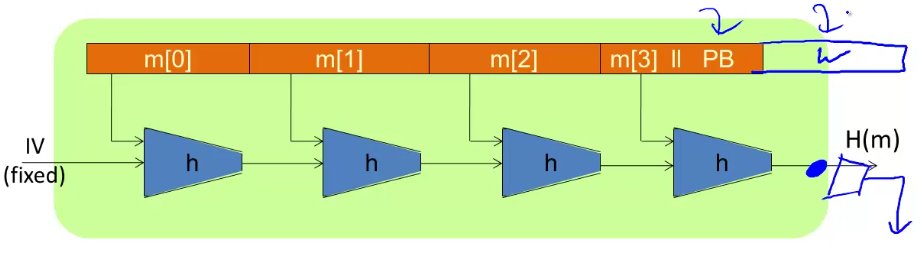

# Code

In [134]:
key = b'secret_key2'
m1 = b'some_message'
m2 = b'my_message'
sha256 = SHA256()
h1 = sha256.encrypt(bytes_to_long(key + m1))
print(hex(h1))

0xa6677ab1ca6dfb7fb1ce8fc58a5eb11409ad4b07d9f50e946676fb91917036bc


In [147]:
#given h1 forge another message

my_sha256 = SHA256()
#get the new iv blocks
my_iv = split_blocks(h1, 32, 8)

#now, encrypting directly (m2) with the new iv won't work because of the padding

# don't forget to pad the new message
m2_pad = my_sha256.pad2(bytes_to_long(m2), 512) + 512 # add 512 for the last message (if the message is longer, add more)
#print(long_to_bytes(m2_pad))

#Continue encrypting using the new iv and the padded m2
ts = my_sha256.merkle_damgard_construction(m2_pad, my_iv)

#reconstruct the hash 
h2 = 0
for i, ti in enumerate(ts):
    h2|=( ti << (32 * (7-i)))
print(hex(h2))

0xeaec719aac4e2e7810ddece4101dcc6cc465d4017c3e928a683f1abfa1b58c22


In [150]:
#check to see if it's good
msg = long_to_bytes(my_sha256.pad2(bytes_to_long(key + m1), 512)) + m2
#print(msg)
h3 = sha256.encrypt(bytes_to_long(msg))
print(hex(h3))
print(h2 == h3)

0xeaec719aac4e2e7810ddece4101dcc6cc465d4017c3e928a683f1abfa1b58c22
True


# Resources

- https://en.wikipedia.org/wiki/Length_extension_attack
- https://crypto.stackexchange.com/questions/3978/understanding-the-length-extension-attack